# 1. Introduction to object detection

This notebook is motivated by fast.ai's course.

As an introduction to object detection, I will train a neural network which will find the largest object in the image, and draw a bounding box around it.

In [1]:
%matplotlib inline

In [2]:
import torch
import voc
from pathlib import Path

Pick one

In [3]:
device = torch.device("cuda:0")
# device = torch.device('cpu')

1. Let's take a look at the data

Note that I haven't rearranged the data from when I downloaded it on the [VOC website](http://host.robots.ox.ac.uk/pascal/VOC/). I downloaded the 2007 dataset. 

Showing VOC2007/Annotations/002508.xml


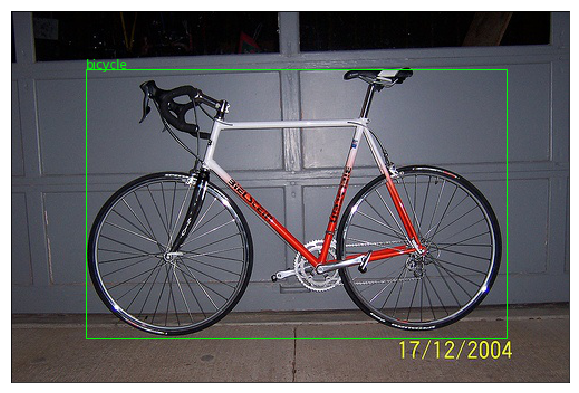

In [4]:
annotation = voc.utils.show_random_example(return_annotation=True)

For this exercise, we will only be recognizing the largest object in the image, so given the annotations, I want to find the largest object.

In [5]:
filtered = voc.utils.keep_largest_box(annotation)

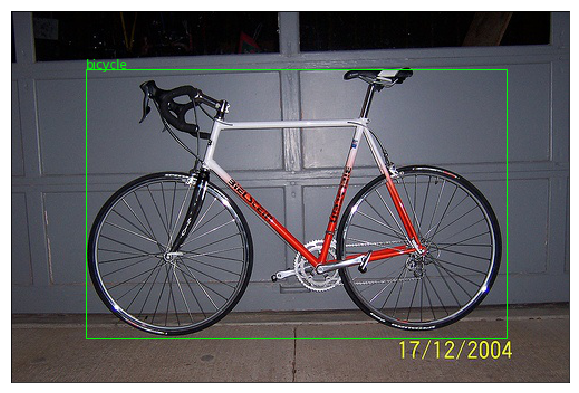

In [6]:
voc.utils.show_annotation(filtered)

Awesome. So now, I have annotations, and images. I want to turn these into iterables I can pass to a neural network.

There are a few things I need to do to train the model:

1. Define the training and validation datasets
2. Find the 'loss weight'; the ratio which will allow me to compare the bounding box loss and the label loss
3. Find the minimum and maximum learning rates, so that I can use a cyclical learning rate
4. Train the model!

In [7]:
import numpy as np
from collections import defaultdict
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

### 1. Defining the datasets

The dataset objects take as input a mask, which allow me to split the data into training and validation data.

In [8]:
total_dataset = voc.datasets.VOCDataset()

Now that we know the size of the dataset, we can use this to create a mask

In [9]:
train_mask = np.random.rand(len(total_dataset)) < 0.8
val_mask = ~train_mask

In [10]:
train_images = voc.datasets.ImageDataset(mask=train_mask, normalizer='imagenet', 
                                         random_transform=True, resize=(224, 224), device=device)

In [11]:
label2class = train_images.get_labels_from_classes()

In [12]:
val_images = voc.datasets.ImageDataset(mask=val_mask, normalizer='imagenet', resize=(224, 224),
                                       label2class=label2class, device=device)

In [13]:
train_dataloader = DataLoader(train_images, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_images, batch_size=64)

### 2. Find a loss weight

Optionally, add a `.cuda()` call if you are running stuff on a GPU.

In [14]:
sod = voc.models.SODNet(num_classes = len(label2class)).cuda()

In [15]:
loss_weight = voc.models.get_sod_weight(sod, next(iter(train_dataloader)))

In [16]:
loss_weight

0.04145914316177368

### 3. Find the minimum and maximum learning rates

In [17]:
bb_criterion = torch.nn.modules.loss.L1Loss()
label_criterion = torch.nn.modules.loss.CrossEntropyLoss()

First, I want to find the best learning rate, as is described in [this paper](https://arxiv.org/abs/1506.01186).

To do this, I'll define a test model and dataloader (with a reduced batch size)

In [18]:
test_sod = voc.models.SODNet(num_classes = len(label2class)).cuda()

starting_learning_rate = 1e-5
ending_learning_rate = 1

total_loss = []
learning_rate_progression = []

test_dataloader = DataLoader(train_images, batch_size=64, shuffle=True)
parameters_to_update = [parameters for name, parameters in test_sod.named_parameters() if 'finetune' in name]

for batch_number, batch in (enumerate(tqdm(test_dataloader))):
    
        addition = (batch_number / len(test_dataloader)) * (ending_learning_rate - starting_learning_rate)
        learning_rate = starting_learning_rate + addition
        # create a new optimizer with higher learning rates
        optimizer = torch.optim.Adam(parameters_to_update, lr=learning_rate)
        # Zero the gradients of my optimizer - 'reset' it
        optimizer.zero_grad()

        ims, target_bb, target_label = batch
        output_bb, output_labels = test_sod(ims)

        bb_loss = bb_criterion(output_bb, target_bb.float())
        label_loss = label_criterion(output_labels, target_label.long())

        loss = label_loss + (loss_weight * bb_loss)
        total_loss.append(loss.item())
        learning_rate_progression.append(learning_rate)

        loss.backward()
        optimizer.step()

100%|██████████| 64/64 [01:24<00:00,  1.32s/it]


In [19]:
import numpy as np

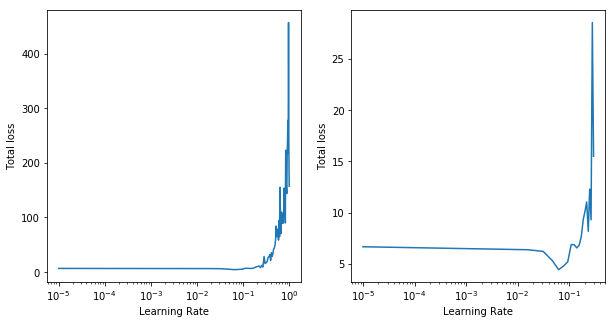

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

# First, lets plot the results from the whole test
axes[0].plot(learning_rate_progression, total_loss)
axes[0].set_xlabel('Learning Rate')
axes[0].set_ylabel('Total loss')
axes[0].set_xscale('log')

# then, clipped
axes[1].plot(learning_rate_progression[:20], total_loss[:20])
axes[1].set_xlabel('Learning Rate')
axes[1].set_ylabel('Total loss')
axes[1].set_xscale('log')

So we can roughly define our `max_lr = 0.07` and our `min_lr=1e-5`

Now, we can create a circular optimizer

In [18]:
min_lr = 1e-5
max_lr = 1e-2

# the paper recommends that each step is around 2 epochs
stepsize = int(len(train_dataloader) + 1 / 2)

In [19]:
parameters_to_update = [parameters for name, parameters in sod.named_parameters() if 'finetune' in name]
optimizer = torch.optim.Adam(parameters_to_update)

In [20]:
cl_scheduler = voc.schedulers.CyclicalLR(optimizer, stepsize, min_lr, max_lr)

I can test this too, to see how the learning rate will change

In [21]:
lr_change = cl_scheduler.test()

Text(0,0.5,'Learning rate')

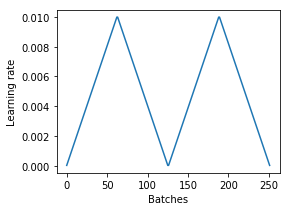

In [22]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(range(len(lr_change)), lr_change)
ax.set_xlabel('Batches')
ax.set_ylabel('Learning rate')

### 4. Training the model

Let's create a new optimizer for our 'real' model.

In [23]:
# num epochs should be %4, so that the end of training coincides with the
# minimum learning rate

num_epochs = 4

In [24]:
for epoch in range(num_epochs):
    # set model to train
    sod.train()

    # Keep track of my loss, so I can display it
    running_train_scores = defaultdict(list)

    # Iterate through my batches
    for batch_number, batch in (enumerate(tqdm(train_dataloader))):
        # Zero the gradients of my optimizer - 'reset' it
        optimizer.zero_grad()

        ims, target_bb, target_label = batch
        output_bb, output_labels = sod(ims)

        bb_loss = bb_criterion(output_bb, target_bb.float())
        label_loss = label_criterion(output_labels, target_label.long())

        loss = label_loss + (loss_weight * bb_loss)

        loss.backward()
        optimizer.step()
        # For display purposes:
        running_train_scores['bb'].append(bb_loss.item())
        running_train_scores['label'].append(label_loss.item())
        running_train_scores['accuracy'].append(voc.models.accuracy(output_labels, target_label))
        
        # note that the step happens every batch, not every epoch
        cl_scheduler.step()

    train_output_strings = []
    for key, val in running_train_scores.items():
        train_output_strings.append('{}: {}'.format(key, round(np.array(val).mean(), 5)))

    # now, lets see how we did on the validation set
    if val_dataloader:
        sod.eval()
        running_val_scores = defaultdict(list)
        for batch_number, batch in (enumerate(val_dataloader)):
            val_ims, val_bb, val_lab = batch
            output_bb, output_labels = sod(val_ims)

            running_val_scores['bb'].append(bb_criterion(output_bb, val_bb.float()).item())
            running_val_scores['label'].append(label_criterion(output_labels, val_lab.long()).item())
            running_val_scores['accuracy'].append(voc.models.accuracy(output_labels, val_lab))
        val_output_strings = []
        for key, val in running_val_scores.items():
            val_output_strings.append('{}: {}'.format(key, round(np.array(val).mean(), 5)))
        print('TRAINING: {}, {}, {}'.format(*train_output_strings))
        print('VALIDATION: {}, {}, {}'.format(*val_output_strings))

  0%|          | 0/63 [00:00<?, ?it/s]

TRAINING: bb: 48.76411, label: 1.85186, accuracy: 0.47375
VALIDATION: bb: 32.05722, label: 1.21585, accuracy: 0.60592


  0%|          | 0/63 [00:00<?, ?it/s]

TRAINING: bb: 29.53747, label: 1.21612, accuracy: 0.62325
VALIDATION: bb: 25.72436, label: 1.07391, accuracy: 0.65482


  0%|          | 0/63 [00:00<?, ?it/s]

TRAINING: bb: 28.32093, label: 1.02663, accuracy: 0.67385
VALIDATION: bb: 26.0956, label: 1.14925, accuracy: 0.6207


100%|██████████| 63/63 [01:25<00:00,  1.35s/it]


TRAINING: bb: 28.89661, label: 1.06862, accuracy: 0.66308
VALIDATION: bb: 25.46901, label: 1.01316, accuracy: 0.6569


Finally, lets check how the model does on real data!

In [25]:
from voc.utils import denormalize, plot_image

In [26]:
imagenet = train_images.get_normalizer()

In [27]:
sod.eval();

In [28]:
val_ims, bbs, labels = next(iter(val_dataloader))

In [29]:
output_bb, output_labels = sod(val_ims)

Lets take the first 4 images to plot

In [30]:
bb_to_plot = output_bb[:4].detach().cpu().numpy()
lab_to_plot = torch.nn.functional.softmax(output_labels[:4], dim=1).argmax(dim=1).detach().cpu().numpy()
im_to_plot = val_ims[:4].detach().cpu().numpy()

In [31]:
class2label = {idx: val for val, idx in label2class.items()}

In [32]:
labels_to_plot = [class2label[idx] for idx in lab_to_plot]

In [33]:
denormed_ims = [denormalize(im, imagenet['mean'], imagenet['std']) for im in im_to_plot]

In [34]:
org_bbs = bbs[:4].detach().cpu().numpy()
org_labels = labels[:4].detach().cpu().numpy()

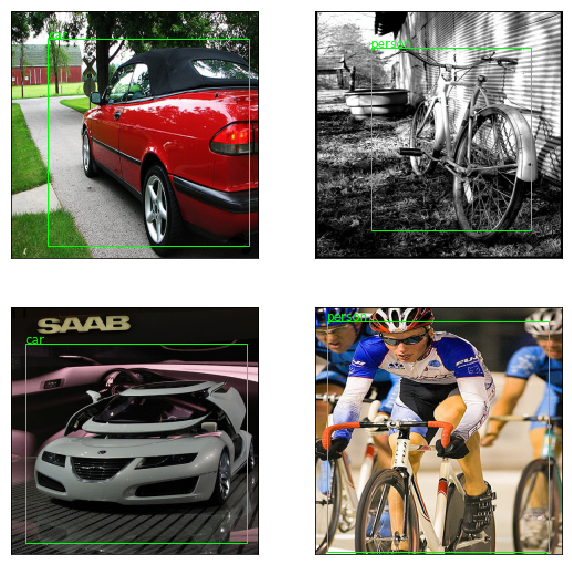

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for image, bb, label, ax in zip(denormed_ims, bb_to_plot, labels_to_plot, axes.reshape(-1)):
    plot_image(image, [bb], [label], ax=ax)
plt.show()